In [94]:
import psycopg2, psycopg2.extensions, psycopg2.extras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Uvoz podatkov

In [10]:
################
#priklop na bazo
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE) # se znebimo problemov s sumniki
baza = psycopg2.connect(database='sem2018_metodj', host='baza.fmf.uni-lj.si', user='metodj', password='gilbertarenas0')
baza.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT) 
cur = baza.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [24]:
################
#test priklopa na bazo
def test(tmp):
    cur.execute('''
                    SELECT * FROM dftest 
                ''', [tmp])
    return (cur.fetchall())

#print(test('')[0])

In [26]:
################
#preprocessing
data = test('')
baza = []
for i in range(len(data)):
    tmp = dict()
    tmp['ime'] = data[i][0]
    tmp['spol'] =  data[i][1]
    tmp['zveznaDržava'] = data[i][2]
    tmp['višina'] = data[i][3]
    tmp['plača'] = data[i][4]
    baza.append(tmp)

data = pd.DataFrame(baza)
data['spol'] = np.where(data['spol']=='Male', 'M', 'Ž')
data.head()

,ime,plača,spol,višina,zveznaDržava
0,Montague Goard,3650,M,1.73,TX
1,Danica Di Biaggi,4207,Ž,1.46,SC
2,Patsy Byre,3608,Ž,1.76,NV
3,Tobit Rolling,3490,M,1.74,OR
4,Herculie Dally,2294,M,1.89,MN


# Laplacov mehanizem za numerične podatke (perturbacija podatkovne baze)

In [30]:
#izracun diametra (preveri veljavnost!!)
def diameter(data):
    return max(abs(x[0] - x[1]) for x in zip(data[1:], data))

In [149]:
#nastavi 'plača' ali 'višina'
podatki= list(float(i) for i in data['plača'])
epsilon = 1
delta = 0.5
b = diameter(podatki)/(epsilon - np.log(1-delta))

df_podatki = map(lambda elem: round(elem + np.random.laplace(0,b),2), podatki)

In [150]:
#osnovna primerjava
print(podatki[:5])
print(df_podatki[:5])
print(diameter(podatki))
print(b)

[3650.0, 4207.0, 3608.0, 3490.0, 2294.0]
[3733.51, 6599.02, 4698.46, -1064.67, -1893.68]
2868.0
1693.88700104


In [151]:
#poračunanih nekaj osnovnih statistik za primerjavo
print(sum(podatki)/len(podatki))
print(sum(df_podatki)/len(df_podatki))
print(max(podatki), min(podatki))
print(max(df_podatki), min(df_podatki))

#poglej še povprečje ženski moški

2995.072
3151.22206
(4500.0, 1504.0)
(14881.6, -8081.19)


In [152]:
#spodnja meja za največjo napako (izrek 5.3)
spodnja_meja = (1-delta)*diameter(podatki)/(2*(1+np.exp(epsilon)))
spodnja_meja

192.8309991222865

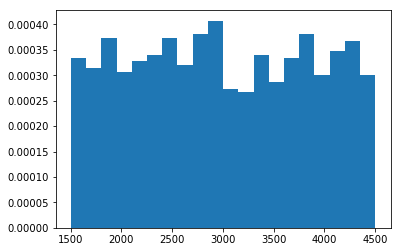

In [55]:
%matplotlib inline
plt.hist(podatki, normed=True, bins=20);

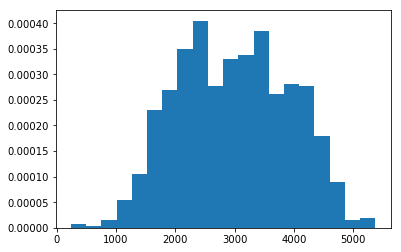

In [56]:
plt.hist(df_podatki, normed=True, bins=20);

# Mehanizem za diskretne podatke (perturbacija podatkovne baze)

In [140]:
epsilon2 = 2
delta2 = 0.5

In [141]:
#zvezne države

m = 47 # |D| = 48, torej imamo v bazi 48 različnih zveznih držav
p = (1 - delta2) / (m + np.exp(epsilon2))

print(p)
print(1-p*m)

drzave = list(str(i) for i in data['zveznaDržava'])
seznam_drzav = list(set(drzave))

df_drzave = []
for i in range(len(drzave)):
    if np.random.uniform(0,1) < (1-p*m):
        df_drzave.append(drzave[i])
    else:
        tmp = list(seznam_drzav)
        tmp.remove(drzave[i])
        df_drzave.append(random.choice(tmp))

0.00919302587437
0.567927783905


In [142]:
#osnovna primerjava
print(drzave[:10])
print(df_drzave[:10])

['TX', 'SC', 'NV', 'OR', 'MN', 'MO', 'WA', 'NC', 'UT', 'MN']
['TX', 'SC', 'NV', 'OR', 'MN', 'MO', 'IL', 'NC', 'UT', 'MN']


In [143]:
#poračunanih nekaj osnovnih statistik za primerjavo
def most_common(lst):
    return max(set(lst), key=lst.count)

print(most_common(drzave))
print(most_common(df_drzave))

TX
TX


In [144]:
#spodnja meja za največjo napako (izrek 5.4)
spodnja_meja = (1-delta2)*m/(m+np.exp(epsilon2))
spodnja_meja

0.43207221609536328

In [145]:
counter = 0
for i in range(len(drzave)):
    if drzave[i] != df_drzave[i]:
        counter += 1;

print(counter)

398


In [146]:
#spol (enostaven primer, naš odzivni mehanizem bo kar Bernoullijeva slučanja spremenljivka)

m = 1 # |D| = 2, moški in ženski spol
p = (1 - delta2) / (m + np.exp(epsilon2))

print(p)
print(1-p*m)

0.0596014610111
0.940398538989


# Primer funkcijskih podatkov - kernel density estimation

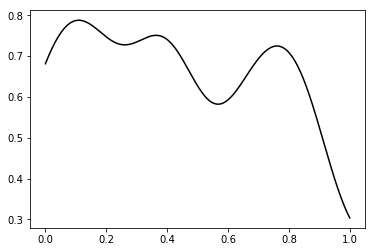

In [84]:
seznam = [numpy.random.normal(0.3,0.5) for _ in range(100)] #+ [numpy.random.normal(0.7,1) for _ in range(50)]

def tmp(x,):
    return x

def f(x, h=0.1,d=1):
    return (1/(len(seznam)*(2*np.pi*h**2)**(d*0.5)))*sum(map(lambda elem: np.exp(-((elem-x)**2)/(2*h**2)),seznam))

f(0.3)

t1 = np.arange(0, 1,0.001)

plt.plot(t1, f(t1), 'k')

plt.show()

In [75]:
print(seznam[:2])
print(map(lambda elem: np.exp(-((elem-0.2)**2)/(2*h**2)),seznam)[:2])

[2.2995011027979304, -1.6692570326003957]
[1.9211517864265509e-96, 1.3369279017133246e-76]


In [63]:
np.exp(-((seznam[0]-0.2)**2)/(2*h**2))

5.2554870187714282e-20

# Delovna verzija

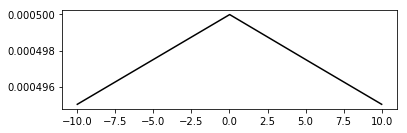

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-abs(x)/b) / (2*b)

t1 = np.arange(-10, 10.0, 0.001)


plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'k')

plt.show()